Define Directories and Arguments

In [1]:
import os

# Set directories
project_dir = "/content/drive/MyDrive/CS2822_Final_Project"
models_dir = os.path.join(project_dir, "Models")
datasets_dir = os.path.join(project_dir, "Datasets")
data_dir = os.path.join(datasets_dir, "spawrious224__o2o_medium.tar.gz")
MODEL_NAME = "resnet18.a1_in1k"
model_checkpoint = "entire_dataset_resnet18.a1-e=12-lr=0.01_limit=20.pt"
cls = "corgi"
cls_idx = 1

# Artificially create args
class Args:
    def __init__(self, model="siglip",
                 dataset="o2o_easy", data_dir='/content/data/',
                 num_epochs=2, val_split=0.1,
                 batch_size=12,num_workers=2, lr=0.01, momentum=0.9, num_images = 300):
        self.model = model
        self.dataset = dataset
        self.data_dir = data_dir
        self.num_epochs = num_epochs
        self.val_split = val_split
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.lr = lr
        self.momentum = momentum
        self.num_images = num_images

# Initialize Args
args = Args(model = "resnet", batch_size=32, num_images=32*10)

#Load Dependencies

In [2]:
import argparse

import torch
import torch.optim as optim
from torch import nn
from torch.nn import Module
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm
from tqdm.auto import tqdm
import timm
import wandb
import os
import matplotlib.pyplot as plt

# 0. Spawrious Source Code

Initializes dataloaders and dataset lists -- with some modifications from source code.


In [3]:
import os
import tarfile
import urllib
import urllib.request
from typing import Any, Tuple

import torch
from PIL import Image
from torch.utils.data import ConcatDataset, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import timm
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

# MODEL_NAME = "vit_so400m_patch14_siglip_384"
# MODEL_NAME = 'swin_base_patch4_window7_224.ms_in22k_ft_in1k'
# MODEL_NAME = 'deit3_base_patch16_224.fb_in22k_ft_in1k'
# MODEL_NAME = 'beit_base_patch16_224.in22k_ft_in22k_in1k'
# MODEL_NAME = 'eva02_base_patch14_448.mim_in22k_ft_in22k_in1k'
# MODEL_NAME = 'levit_128s.fb_dist_in1k'

def set_model_name(name):
    global MODEL_NAME
    MODEL_NAME = name


def _extract_dataset_from_tar(
    tar_file_name: str, data_dir: str
) -> None:
    tar_file_dst = os.path.join(data_dir, tar_file_name)
    print("Extracting dataset...")
    tar = tarfile.open(tar_file_dst, "r:gz")
    tar.extractall(os.path.dirname(tar_file_dst))
    tar.close()


def _download_dataset_if_not_available(
    dataset_name: str, data_dir: str, remove_tar_after_extracting: bool = True
) -> None:
    """
    datasets.txt file, which is present in the data_dir, is used to check if the dataset is already extracted. If the dataset is already extracted, then the tar file is not downloaded again.
    """
    data_dir = data_dir.split("/spawrious224/")[
        0
    ]  # in case people pass in the wrong root_dir
    os.makedirs(data_dir, exist_ok=True)
    dataset_name = dataset_name.lower()
    if dataset_name.split("_")[0] == "m2m":
        dataset_name = "entire_dataset"
    url_dict = {
        "entire_dataset": "https://www.dropbox.com/s/hofkueo8qvaqlp3/spawrious224__entire_dataset.tar.gz?dl=1",
        "o2o_easy": "https://www.dropbox.com/s/kwhiv60ihxe3owy/spawrious224__o2o_easy.tar.gz?dl=1",
        "o2o_medium": "https://www.dropbox.com/s/x03gkhdwar5kht4/spawrious224__o2o_medium.tar.gz?dl=1",
        "o2o_hard": "https://www.dropbox.com/s/p1ry121m2gjj158/spawrious224__o2o_hard.tar.gz?dl=1",
        # "m2m": "https://www.dropbox.com/s/5usem63nfub266y/spawrious__m2m.tar.gz?dl=1",
    }
    tar_file_name = f"spawrious224__{dataset_name}.tar.gz"
    tar_file_dst = os.path.join(data_dir, tar_file_name)
    url = url_dict[dataset_name]

    # check if the dataset is already extracted
    if _check_images_availability(data_dir, dataset_name):
        print("Dataset already downloaded and extracted.")
        return
    # check if the tar file is already downloaded
    else:
        if os.path.exists(tar_file_dst):
            print("Dataset already downloaded. Extracting...")
            _extract_dataset_from_tar(
                tar_file_name, data_dir
            )
            return
        # download the tar file and extract from it
        else:
            print("Dataset not found. Downloading...")
            response = urllib.request.urlopen(url)
            total_size = int(response.headers.get("Content-Length", 0))
            block_size = 1024
            # Track progress of download
            progress_bar = tqdm(total=total_size, unit="iB", unit_scale=True)
            with open(tar_file_dst, "wb") as f:
                while True:
                    buffer = response.read(block_size)
                    if not buffer:
                        break
                    f.write(buffer)
                    progress_bar.update(len(buffer))
            progress_bar.close()
            print("Dataset downloaded. Extracting...")
            _extract_dataset_from_tar(
                tar_file_name, data_dir
            )
            return


class CustomImageFolder(Dataset):
    """
    A class that takes one folder at a time and loads a set number of images in a folder and assigns them a specific class
    """

    def __init__(
        self, folder_path, class_index, location_index, limit=None, transform=None
    ):
        self.folder_path = folder_path
        self.class_index = class_index
        self.location_index = location_index
        self.image_paths = [
            os.path.join(folder_path, img)
            for img in os.listdir(folder_path)
            if img.endswith((".png", ".jpg", ".jpeg"))
        ]
        if limit:
            self.image_paths = self.image_paths[:limit]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index: int) -> Tuple[Any, Any, Any]:
        img_path = self.image_paths[index]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        class_label = torch.tensor(self.class_index, dtype=torch.long)
        location_label = torch.tensor(self.location_index, dtype=torch.long)
        return img, class_label, location_label


class MultipleDomainDataset:
    N_STEPS = 5001  # Default, subclasses may override
    CHECKPOINT_FREQ = 100  # Default, subclasses may override
    N_WORKERS = 8  # Default, subclasses may override
    ENVIRONMENTS = None  # Subclasses should override
    INPUT_SHAPE = None  # Subclasses should override

    def __getitem__(self, index):
        return self.datasets[index]

    def __len__(self):
        return len(self.datasets)


def build_combination(benchmark_type, group, test, filler=None):
    total = 3168
    combinations = {}
    if "m2m" in benchmark_type:
        counts = [total, total]
        combinations["train_combinations"] = {
            ("bulldog",): [(group[0], counts[0]), (group[1], counts[1])],
            ("dachshund",): [(group[1], counts[0]), (group[0], counts[1])],
            ("labrador",): [(group[2], counts[0]), (group[3], counts[1])],
            ("corgi",): [(group[3], counts[0]), (group[2], counts[1])],
        }
        combinations["test_combinations"] = {
            ("bulldog",): [test[0], test[1]],
            ("dachshund",): [test[1], test[0]],
            ("labrador",): [test[2], test[3]],
            ("corgi",): [test[3], test[2]],
        }
    else:
        counts = [int(0.97 * total), int(0.87 * total)]
        combinations["train_combinations"] = {
            ("bulldog",): [(group[0], counts[0]), (group[0], counts[1])],
            ("dachshund",): [(group[1], counts[0]), (group[1], counts[1])],
            ("labrador",): [(group[2], counts[0]), (group[2], counts[1])],
            ("corgi",): [(group[3], counts[0]), (group[3], counts[1])],
            ("bulldog", "dachshund", "labrador", "corgi"): [
                (filler, total - counts[0]),
                (filler, total - counts[1]),
            ],
        }
        combinations["test_combinations"] = {
            ("bulldog",): [test[0], test[0]],
            ("dachshund",): [test[1], test[1]],
            ("labrador",): [test[2], test[2]],
            ("corgi",): [test[3], test[3]],
        }
    return combinations


def _get_combinations(benchmark_type: str) -> Tuple[dict, dict]:
    combinations = {
        "o2o_easy": (
            ["desert", "jungle", "dirt", "snow"],
            ["dirt", "snow", "desert", "jungle"],
            "beach",
        ),
        "o2o_medium": (
            ["mountain", "beach", "dirt", "jungle"],
            ["jungle", "dirt", "beach", "snow"],
            "desert",
        ),
        "o2o_hard": (
            ["jungle", "mountain", "snow", "desert"],
            ["mountain", "snow", "desert", "jungle"],
            "beach",
        ),
        "m2m_hard": (
            ["dirt", "jungle", "snow", "beach"],
            ["snow", "beach", "dirt", "jungle"],
            None,
        ),
        "m2m_easy": (
            ["desert", "mountain", "dirt", "jungle"],
            ["dirt", "jungle", "mountain", "desert"],
            None,
        ),
        "m2m_medium": (
            ["beach", "snow", "mountain", "desert"],
            ["desert", "mountain", "beach", "snow"],
            None,
        ),
    }
    if benchmark_type not in combinations:
        raise ValueError("Invalid benchmark type")
    group, test, filler = combinations[benchmark_type]
    return build_combination(benchmark_type, group, test, filler)


class SpawriousBenchmark(MultipleDomainDataset):
    ENVIRONMENTS = ["Test", "SC_group_1", "SC_group_2"]
    input_shape = (3, 224, 224)
    num_classes = 4
    class_list = ["bulldog", "corgi", "dachshund", "labrador"]
    locations_list = ["desert", "jungle", "dirt", "mountain", "snow", "beach"]

    def __init__(self, benchmark, root_dir, augment=True):
        combinations = _get_combinations(benchmark.lower())
        self.type1 = benchmark.lower().startswith("o2o")
        train_datasets, test_datasets = self._prepare_data_lists(
            combinations["train_combinations"],
            combinations["test_combinations"],
            root_dir,
            augment,
        )
        self.datasets = [ConcatDataset(test_datasets)] + train_datasets

    def get_train_dataset(self):
        return torch.utils.data.ConcatDataset(self.datasets[1:])

    def get_test_dataset(self):
        return self.datasets[0]

    # Prepares the train and test data lists by applying the necessary transformations.
    def _prepare_data_lists(
        self, train_combinations, test_combinations, root_dir, augment
    ):
        backbone = timm.create_model(
            # "vit_so400m_patch14_siglip_384",
            MODEL_NAME,
            pretrained=True,
            num_classes=0,
        ).eval()
        self.data_config = timm.data.resolve_model_data_config(backbone)
        test_transforms = timm.data.create_transform(
            **self.data_config, is_training=False
        )

        # test_transforms = transforms.Compose(
        #     [
        #         transforms.Resize((self.input_shape[1], self.input_shape[2])),
        #         transforms.transforms.ToTensor(),
        #         transforms.Normalize(
        #             mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        #         ),
        #     ]
        # )

        if augment:
            train_transforms = timm.data.create_transform(
                **self.data_config, is_training=True
            )
        else:
            train_transforms = test_transforms
        print("Creating Training Dataset:")
        train_data_list = self._create_data_list(
            train_combinations, root_dir, train_transforms
        )
        print("Creating Testing Dataset:")
        test_data_list = self._create_data_list(
            test_combinations, root_dir, test_transforms
        )

        return train_data_list, test_data_list

    # Creates a list of datasets based on the given combinations and transformations.
    def _create_data_list(self, combinations, root_dir, transforms):
        data_list = []
        if isinstance(combinations, dict):
            # Build class groups for a given set of combinations, root directory, and transformations.
            for_each_class_group = []
            cg_index = 0
            for classes, comb_list in combinations.items():
                for_each_class_group.append([])
                for ind, location_limit in enumerate(comb_list):
                    if isinstance(location_limit, tuple):
                        location, limit = location_limit
                    else:
                        location, limit = location_limit, None
                    cg_data_list = []
                    for cls in classes:
                        path = os.path.join(
                            root_dir,
                            "spawrious224",
                            f"{0 if not self.type1 else ind}/{location}/{cls}",
                        )
                        print(f"    Combination: {0 if not self.type1 else ind}/{location}/{cls}")
                        print(f"    Limit: {limit}")
                        data = CustomImageFolder(
                            folder_path=path,
                            class_index=self.class_list.index(cls),
                            location_index=self.locations_list.index(location),
                            limit=limit,
                            transform=transforms,
                        )
                        cg_data_list.append(data)

                    for_each_class_group[cg_index].append(ConcatDataset(cg_data_list))
                cg_index += 1

            for group in range(len(for_each_class_group[0])):
                data_list.append(
                    ConcatDataset(
                        [
                            for_each_class_group[k][group]
                            for k in range(len(for_each_class_group))
                        ]
                    )
                )
        else:
            for location in combinations:
                path = os.path.join(root_dir, f"{0}/{location}/")
                data = ImageFolder(root=path, transform=transforms)
                data_list.append(data)

        return data_list


def _check_images_availability(root_dir: str, dataset_type: str) -> bool:
    # Get the combinations for the given dataset type
    root_dir = root_dir.split("/spawrious224/")[
        0
    ]  # in case people pass in the wrong root_dir
    if dataset_type == "entire_dataset":
        for dataset in ["0", "1", "domain_adaptation_ds"]:
            for location in ["snow", "jungle", "desert", "dirt", "mountain", "beach"]:
                for cls in ["bulldog", "corgi", "dachshund", "labrador"]:
                    path = os.path.join(
                        root_dir, "spawrious224", f"{dataset}/{location}/{cls}"
                    )
                    if not os.path.exists(path) or not any(
                        img.endswith((".png", ".jpg", ".jpeg"))
                        for img in os.listdir(path)
                    ):
                        return False
        return True
    combinations = _get_combinations(dataset_type.lower())

    # Extract the train and test combinations
    train_combinations = combinations["train_combinations"]
    test_combinations = combinations["test_combinations"]

    # Check if the relevant images for each combination are present in the root directory
    for combination in [train_combinations, test_combinations]:
        for classes, comb_list in combination.items():
            for ind, location_limit in enumerate(comb_list):
                if isinstance(location_limit, tuple):
                    location, limit = location_limit
                else:
                    location, limit = location_limit, None

                for cls in classes:
                    path = os.path.join(
                        root_dir,
                        "spawrious224",
                        f"{0 if not dataset_type.lower().startswith('o2o') else ind}/{location}/{cls}",
                    )

                    # If the path does not exist or there are no relevant images, return False
                    if not os.path.exists(path) or not any(
                        img.endswith((".png", ".jpg", ".jpeg"))
                        for img in os.listdir(path)
                    ):
                        return False

    # If all the required images are present, return True
    return True


def get_spawrious_dataset(root_dir: str, dataset_name: str = "entire_dataset"):
    """
    Returns the dataset as a torch dataset, and downloads dataset if dataset is not already available.

    By default, the entire dataset is downloaded, which is necessary for m2m experiments, and domain adaptation experiments
    """
    root_dir = root_dir.split("/spawrious224/")[
        0
    ]  # in case people pass in the wrong root_dir
    assert dataset_name.lower() in {
        "o2o_easy",
        "o2o_medium",
        "o2o_hard",
        "m2m_easy",
        "m2m_medium",
        "m2m_hard",
        "m2m",
        "entire_dataset",
    }, f"Invalid dataset type: {dataset_name}"
    _download_dataset_if_not_available(dataset_name, root_dir)
    # TODO: get m2m to use entire dataset, not half of it
    return SpawriousBenchmark(dataset_name, root_dir, augment=True)

In [4]:
# Class to modify model
class ClassifierOnTop(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = timm.create_model(
            # "vit_so400m_patch14_siglip_384",
            MODEL_NAME,
            pretrained=True,
            num_classes=0,
        ).eval()
        self.linear = nn.Linear(1152, num_classes)
        if MODEL_NAME == 'swin_base_patch4_window7_224.ms_in22k_ft_in1k':
            self.linear = nn.Linear(1024, num_classes)
        elif MODEL_NAME == 'deit3_base_patch16_224.fb_in22k_ft_in1k':
            self.linear = nn.Linear(768, num_classes)
        elif MODEL_NAME == 'beit_base_patch16_224.in22k_ft_in22k_in1k':
            self.linear = nn.Linear(768, num_classes)
        elif MODEL_NAME == 'eva02_base_patch14_448.mim_in22k_ft_in22k_in1k':
            self.linear = nn.Linear(768, num_classes)
        elif MODEL_NAME == 'levit_128s.fb_dist_in1k':
            self.linear = nn.Linear(384, num_classes)

    def forward(self, x):
        with torch.no_grad():
            x = self.backbone(x)
        return self.linear(x)


def get_model(args: argparse.Namespace) -> Module:
    if args.model == "siglip":
        model = ClassifierOnTop(num_classes=4)
    else:
        model = models.resnet18(pretrained=True)
        model.fc = torch.nn.Linear(512, 4)
    return model


#1. Load Dataset

In [5]:
# Mount google drive to local dir
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
# Create data dir
!mkdir /content/data

In [7]:
# Set Model Name (using global var)
set_model_name(MODEL_NAME)

In [8]:
import tarfile

# Unzip thes snow-corgi dataset
drive_dir = os.path.join(datasets_dir, "1-snow-corgi.tar.gz")
!cp $drive_dir /content/data
tar_file = os.path.join('/content/data', drive_dir.split('/')[-1])
data_dir = "/content/data/spawrious224/1/snow/"

# Extract the snow-corgi dataset
with tarfile.open(tar_file, 'r:gz') as tar:  # Use 'r' for .tar and 'r:gz' for .tar.gz
    tar.extractall(path=data_dir)

#2. Load Model

In [9]:
# Get model (must be stored in models dir)
# Checks if GPU is available first
if torch.cuda.is_available():
    model_weights = torch.load(os.path.join(models_dir, model_checkpoint))
else:
    model_weights = torch.load(os.path.join(models_dir, model_checkpoint), map_location=torch.device('cpu'))

<ipython-input-9-e395d9224343>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load(os.path.join(models_dir, model_checkpoint))


In [10]:
# Create model backbone (base model)
model = timm.create_model(
            # "vit_so400m_patch14_siglip_384",
            MODEL_NAME,
            pretrained=True,
            num_classes=4).eval()

# Add linear readout for 4 clases, wraps model in custom model class
#model = get_model(args)

# Add on classifier for last 4 classes
model.load_state_dict(model_weights)

# set ENTIRE model to eval mode
model.eval()
model.to('cuda')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

#3. Create Custom Dataloader and Dataset for experiments


Extract only one class (Corgi) and location (snow) as its own dataset

In [11]:
# image plotting code
def plot_img(img):
    image_hwc = np.transpose(img, (1, 2, 0))
    plt.imshow(image_hwc)


Images loaded:  320
Transforms used:
 Compose(
    Resize(size=235, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)
Example Image: 


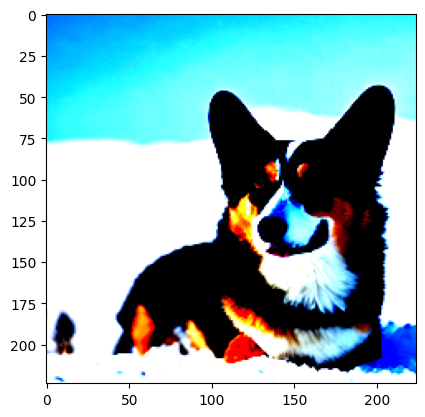

In [12]:
import numpy as np

# Retrieve model transform
# Retrieve model transform
# Retrieve model transform
config = timm.data.resolve_model_data_config(model)
transform = timm.data.create_transform(**config, is_training=False,)

# Checkout the specific dog you are interested in
class_dir = os.path.join("/content/data/spawrious224/1/snow", cls)

# Create a custom image folder (the Spawrious custom class for datasets)
class_data_list = CustomImageFolder(class_dir,
                                   class_index=1, location_index=4,
                                   transform = transform, limit = args.num_images)
no_transforms_list = CustomImageFolder(class_dir,
                                   class_index=1, location_index=4,
                                   transform = None, limit = args.num_images)

print("Images loaded: ", len(class_data_list))
# Checkout model transforms
print("Transforms used:\n", transform)
print("Example Image: ")

# Show the un-transformed and transformed image to ensure the indices line up
idx = np.random.randint(len(class_data_list))
plot_img(class_data_list[idx][0])

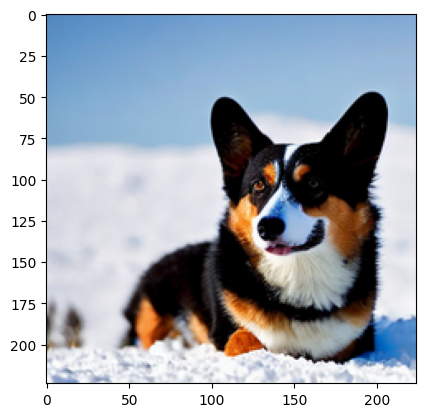

In [13]:
plt.imshow(no_transforms_list[idx][0])

In [14]:
# Create a dataloader
class_loader = torch.utils.data.DataLoader(
    class_data_list,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=args.num_workers,
)

In [15]:
# Test some predictions
features = model.forward_features(class_data_list[20][0].unsqueeze(0).to('cuda'))
print("Features shape: \n", features.shape)
pred = model(class_data_list[20][0].unsqueeze(0).to('cuda'))
print("Predictions: \n", pred)
del pred
del features

Features shape: 
 torch.Size([1, 512, 7, 7])
Predictions: 
 tensor([[-2.7512,  6.3825, -1.5698, -1.7062]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


#4. Concept Extraction with Nonnegative Matrix Factorization

## Helpers

In [16]:
import cv2
from skimage import measure
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np


def set_size(w,h):
  """Set matplot figure size"""
  plt.rcParams["figure.figsize"] = [w,h]

def show(img, norm=True, **kwargs):
  """ Display torch/tf tensor """
  if isinstance(img, torch.Tensor):
    img = img.detach().cpu().numpy()
  img = np.array(img, dtype=np.float32)

  # check if channel first
  if img.shape[0] == 1:
    img = img[0]
  if img.shape[0] == 3:
    img = np.moveaxis(img, 0, 2)
  # check if cmap
  if img.shape[-1] == 1:
    img = img[:,:,0]
  # normalize
  if norm:
    img -= img.min(); img/=img.max()

  plt.imshow(img, **kwargs)
  plt.axis('off')
  plt.grid(None)


all_cmaps = []

def get_alpha_cmap(rgb_color):
    # Normalize the RGB color values to the range [0, 1]
    rgb_color = np.array(rgb_color) / 255.0

    # Create an alpha colormap with varying alpha values
    cmap_data = {'red':   [(0, rgb_color[0], rgb_color[0]),
                           (1, rgb_color[0], rgb_color[0])],
                 'green': [(0, rgb_color[1], rgb_color[1]),
                           (1, rgb_color[1], rgb_color[1])],
                 'blue':  [(0, rgb_color[2], rgb_color[2]),
                           (1, rgb_color[2], rgb_color[2])],
                 'alpha': [(0, 0, 0),
                           (1, 1, 1)]}

    alpha_cmap = mcolors.LinearSegmentedColormap('alpha_cmap', cmap_data, N=256)

    all_cmaps.append(alpha_cmap)

    return alpha_cmap

slack_blue  = get_alpha_cmap((54, 197, 240))
slack_green = get_alpha_cmap((46, 182, 125) )
slack_red   = get_alpha_cmap((210, 40, 95))
slack_yellow = get_alpha_cmap((236, 178, 46))
slack_violet = get_alpha_cmap((84, 25, 85))

google_blue = get_alpha_cmap((66, 133, 244))
google_red = get_alpha_cmap((219, 68, 55))
google_yellow= get_alpha_cmap((244, 180, 0))
google_green = get_alpha_cmap((15, 157, 88))

deep_purple = get_alpha_cmap((103, 58, 183))
pink = get_alpha_cmap((236, 64, 122))
anthracite = get_alpha_cmap((13, 13, 21))

palette_1 = get_alpha_cmap((33, 115, 174))
palette_2 = get_alpha_cmap((216, 146, 49))
palette_3 = get_alpha_cmap((58, 155, 118))
palette_4 = get_alpha_cmap((210, 158, 201))

cmaps = [google_blue, slack_green, slack_red, slack_yellow, slack_violet, anthracite, google_blue, pink, deep_purple]


def create_alpha_cmap(color_input, name=None):
    if isinstance(color_input, str):
        # If the input is a colormap name
        base_cmap = plt.cm.get_cmap(color_input)
    elif isinstance(color_input, tuple) and len(color_input) == 3:
        if np.max(color_input) > 1:
            color_input = (
                color_input[0] / 255,
                color_input[1] / 255,
                color_input[2] / 255,
            )
        if name is None:
            name = f'RGB{color_input}'
        base_cmap = mcolors.LinearSegmentedColormap.from_list(name, [color_input, color_input])
    else:
        raise ValueError("Invalid color_input. Must be a colormap name or an RGB tuple.")

    # alpha values ranging from 0 to 1
    # tfel: useful to start above zero?
    alpha = np.linspace(0.0, 1, base_cmap.N)

    colors = base_cmap(np.arange(base_cmap.N))
    colors[:, -1] = alpha

    alpha_cmap = mcolors.LinearSegmentedColormap.from_list('alpha_cmap', colors)

    return alpha_cmap


# predefine some alpha cmaps
JET_ALPHA = create_alpha_cmap('jet')
VIRIDIS_ALPHA = create_alpha_cmap('viridis')

_tab_10_colors = [
    (31, 119, 180),   # tab:blue
    (255, 127, 14),   # tab:orange
    (44, 160, 44),    # tab:green
    (214, 39, 40),    # tab:red
    (148, 103, 189),  # tab:purple
    (140, 86, 75),    # tab:brown
    (227, 119, 194),  # tab:pink
    (127, 127, 127),  # tab:gray
    (188, 189, 34),   # tab:olive
    (23, 190, 207)    # tab:cyan
]

TAB10_ALPHA = [create_alpha_cmap(color) for color in _tab_10_colors]

cmaps = [google_blue, slack_green, slack_red, slack_yellow, slack_violet, anthracite, google_blue, pink, deep_purple]
cmaps = cmaps + TAB10_ALPHA


def _get_representative_ids(heatmaps, concept_id):
    return np.mean(heatmaps[:, :, :, concept_id], axis=(1, 2)).argsort()[-10:]

def overlay_top_heatmaps(images, heatmaps, concept_id, cmap=None, alpha=0.35):
    assert len(images) == len(heatmaps)
    assert heatmaps.shape[-1] > concept_id
    assert heatmaps.ndim == 4

    if cmap is None:
        cmap = TAB10_ALPHA[concept_id] if heatmaps.shape[-1] < 10 else VIRIDIS_ALPHA
        alpha = 1.0

    best_ids = _get_representative_ids(heatmaps, concept_id)

    for i, idx in enumerate(best_ids):
        image = images[idx]
        heatmap = cv2.resize(heatmaps[idx, :, :, concept_id], (image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)
        #raise NotImplementedError("re implement cv2 resize with bicubic")

        plt.subplot(2, 5, i + 1)
        show(image)
        show(heatmap, cmap=cmap, alpha=alpha)

def evidence_top_images(images, heatmaps, concept_id, percentiles=None):
    assert len(images) == len(heatmaps)
    assert heatmaps.shape[-1] > concept_id
    assert heatmaps.ndim == 4

    if percentiles is None:
        percentiles = np.linspace(50, 95, 10)

    best_ids = _get_representative_ids(heatmaps, concept_id)

    for i, idx in enumerate(best_ids):
        image = images[idx]
        heatmap = cv2.resize(heatmaps[idx, :, :, concept_id], (image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)

        mask = np.zeros_like(heatmap)
        for percentile in percentiles:
            mask[heatmap > np.percentile(heatmap, percentile)] += 1.0
        mask = mask / len(percentiles)

        masked_image = image * mask[:, :, None]

        plt.subplot(2, 5, i + 1)
        show(masked_image.astype(np.uint8))

def zoom_top_images(images, heatmaps, concept_id, zoom_size=100):
    assert len(images) == len(heatmaps)
    assert heatmaps.shape[-1] > concept_id
    assert heatmaps.ndim == 4

    best_ids = _get_representative_ids(heatmaps, concept_id)

    for i, idx in enumerate(best_ids):
        image = images[idx]
        heatmap = cv2.resize(heatmaps[idx, :, :, concept_id], (image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)

        hottest_point = np.unravel_index(np.argmax(heatmap, axis=None), heatmap.shape)

        x_min = max(hottest_point[0] - zoom_size // 2, 0)
        x_max = min(hottest_point[0] + zoom_size // 2, image.shape[0])
        y_min = max(hottest_point[1] - zoom_size // 2, 0)
        y_max = min(hottest_point[1] + zoom_size // 2, image.shape[1])

        zoomed_image = image[x_min:x_max, y_min:y_max]

        plt.subplot(2, 5, i + 1)
        show(zoomed_image)

def contour_top_image(images, heatmaps, concept_id, percentiles=None, cmap="viridis", linewidth=1.0):
    assert len(images) == len(heatmaps)
    assert heatmaps.shape[-1] > concept_id
    assert heatmaps.ndim == 4

    if percentiles is None:
        percentiles = [70]

    best_ids = _get_representative_ids(heatmaps, concept_id)

    for i, idx in enumerate(best_ids):
        image = images[idx]
        plt.subplot(2, 5, i + 1)
        show(image)

        heatmap = cv2.resize(heatmaps[idx, :, :, concept_id], (image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)

        for percentile in percentiles:
            cut_value = np.percentile(heatmap, percentile)
            contours = measure.find_contours(heatmap, cut_value)
            for contour in contours:
                plt.plot(contour[:, 1], contour[:, 0], linewidth=linewidth, color=plt.get_cmap(cmap)(percentile / 100))




<ipython-input-16-db60a7f2c4f4>:83: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = plt.cm.get_cmap(color_input)


In [17]:
model.to('cuda')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

##Implementation

In [18]:
import torch
from sklearn.decomposition import NMF
import torchvision
import timm
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import ceil
import numpy as np

def get_images(data_loader, num_images):
    X = []
    n = 0
    for images, classes, locations in data_loader:
        X.append(images)
        n += data_loader.batch_size
        if n >= num_images:
            return X

def get_stacked_activations(X, num_images):
    # Run forward pass
    A = []
    for batch in X:
        batch = transform(batch)
        batch = batch.to('cuda')
        batch_A = model.forward_features(batch)
        A.append(batch_A.detach().cpu().numpy())

    A = np.concatenate(A, axis=0)
    return A

In [19]:
X = get_images(class_loader, args.num_images)
A = get_stacked_activations(X, args.num_images)
print("Shape of activations: \n", A.shape)

# Convert X to tensor
X_cat = torch.cat(X, dim=0)

Shape of activations: 
 (320, 512, 7, 7)


In [20]:
from einops import rearrange
num_concepts = 8

nmf = NMF(num_concepts)

A_flatten = rearrange(A, 'n c h w -> (n h w) c')

Z = nmf.fit_transform(A_flatten)
D = nmf.components_

Z_heatmaps = rearrange(Z, '(n h w) r -> n h w r', n=A.shape[0], h=7, w=7)
Z_heatmaps.shape

(320, 7, 7, 8)

In [21]:
def load_images_as_np(data_list, num_images=args.num_images):
  X = []
  n = 0
  for entry in data_list:
    X.append(entry[0])
    n += 1
    if n == num_images:
      return np.array(X)

Imgs = load_images_as_np(no_transforms_list)

In [22]:
Imgs.shape

(320, 224, 224, 3)

In [23]:
# most important are E(Z) * W'
# W' is D @ W.T
W = model.fc.weight.detach().cpu().numpy()
W_p = D @ W.T
Importance = np.mean(Z, 0) * W_p[:, cls_idx] # corgi class
Importance.shape

(8,)

Concept 0: 4.138669967651367


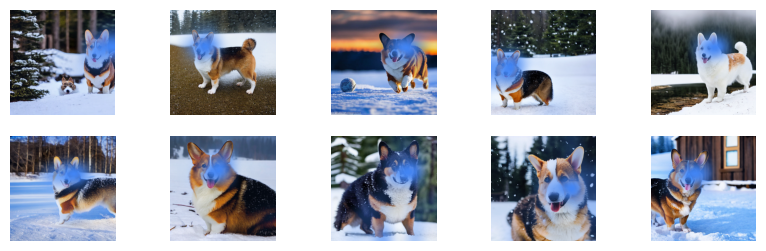

Concept 6: 3.566471576690674


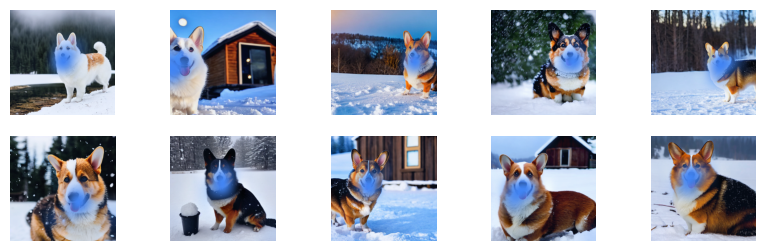

Concept 2: 2.1816112995147705


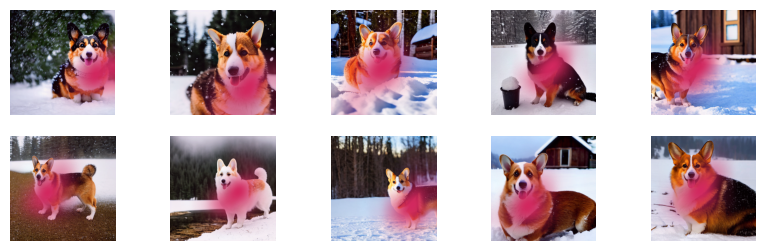

Concept 1: 1.624639868736267


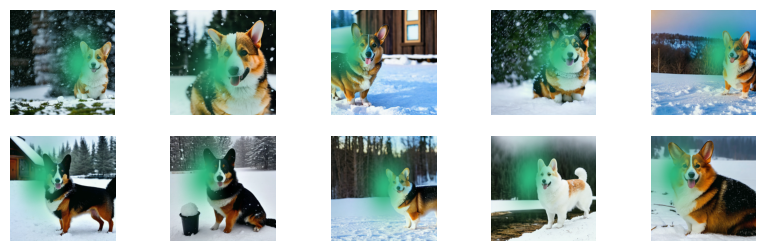

Concept 3: 1.1799384355545044


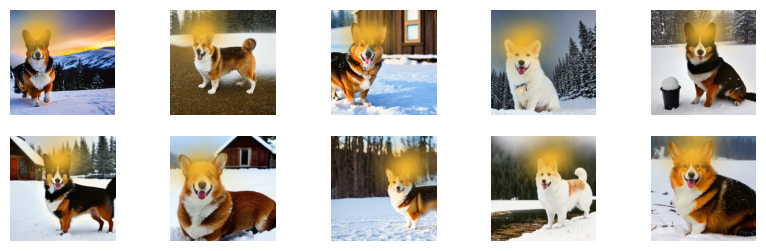

Concept 5: -0.4412108361721039


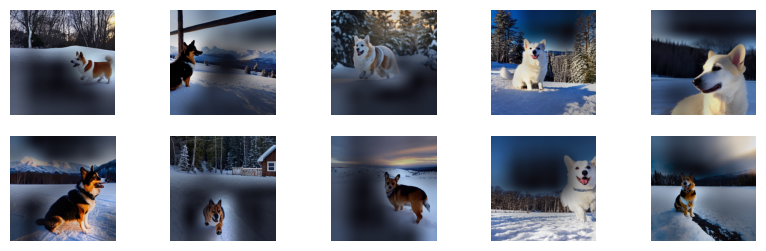

Concept 4: -1.0027952194213867


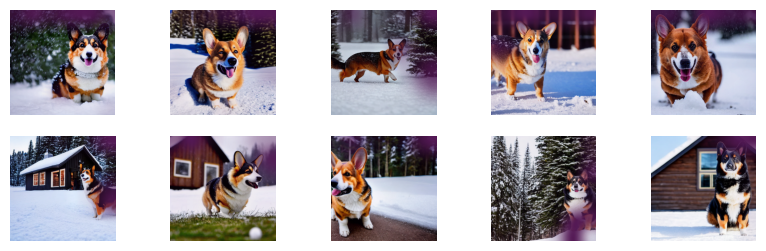

Concept 7: -1.3319133520126343


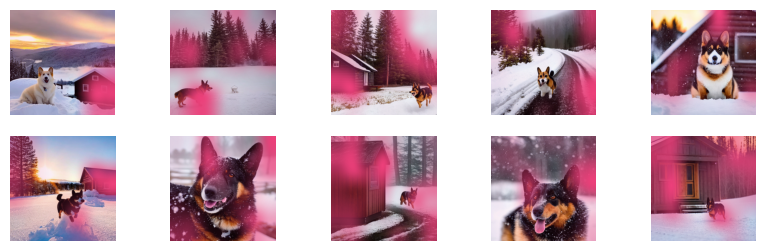

In [24]:
for concept_id in np.argsort(Importance)[::-1]:
  print(f"Concept {concept_id}: {Importance[concept_id]}")
  set_size(10, 3)
  overlay_top_heatmaps(Imgs[:A.shape[0]], Z_heatmaps, concept_id, cmap=cmaps[concept_id], alpha=1.0)
  plt.show()

# 5. Store Results in Drive
As a refresher, we have the following tensors:
- A : the stacked activations of the input images. This undergoes matrix factorization to get D
- D: the concepts
- Z: the attempted reconstruction of A using NMF
- Z_heatmaps: the heatmaps of how prevalent each concept is in each image
- W: Weights of the final layer ; W_p is D @ W.T


In [25]:
# Create Directory, change name as needed
dir_name = f"CRAFT_Corgi_Snow_{args.num_images}_im_{D.shape[0]}_concepts_{model_checkpoint}"
results_dir = os.path.join(project_dir, "Results", dir_name)

os.makedirs(results_dir, exist_ok=True)

# Save concepts
np.save(os.path.join(results_dir, "Concepts.npy"), D)
# Save importances
np.save(os.path.join(results_dir, "Importances.npy"), Importance)
# Data lists
torch.save(class_data_list, os.path.join(results_dir, "data_list.pt"),)
torch.save(no_transforms_list, os.path.join(results_dir, "data_list_no_transforms.pt"),)
# Heatmaps (activations)
np.save(os.path.join(results_dir, "Activations.npy"), Z_heatmaps)

## Optional -- View Concepts with Horama

In [26]:
!pip install -q horama

100%|██████████| 500/500 [00:13<00:00, 37.52it/s]


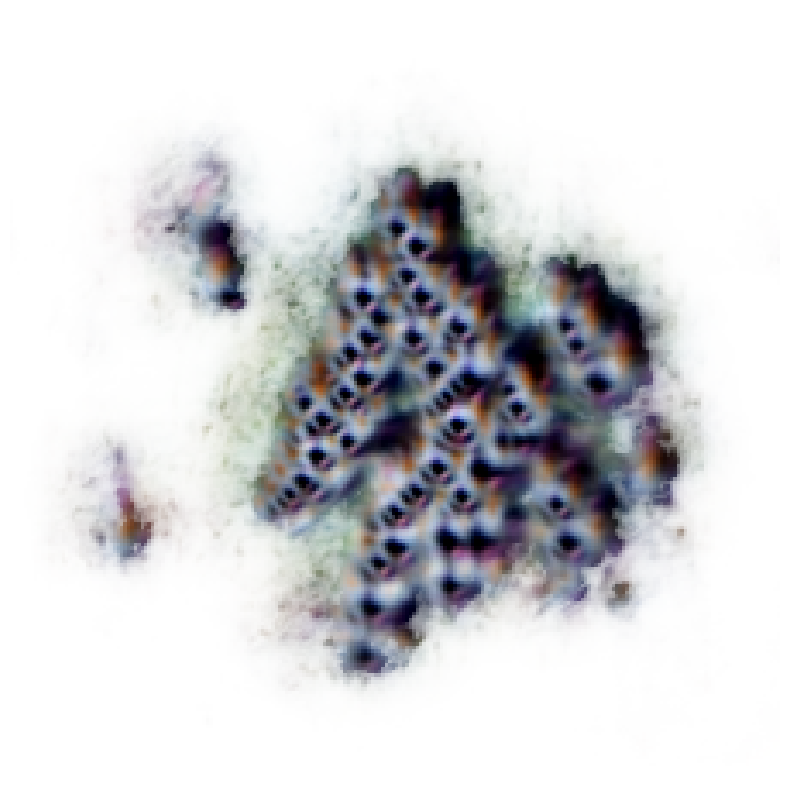

In [ ]:
from horama import maco, plot_maco

D_t = torch.tensor(D).cuda().T
concept_id = 3

def objective(images):
  activations = model.forward_features(images).mean((2,3))
  concept_values_approx = activations @ D_t
  score = concept_values_approx[:, concept_id].mean()
  return score

set_size(10, 10)
image1, alpha1 = maco(objective, image_size=224, total_steps=500)
plot_maco(image1, alpha1)
plt.show()